In [1]:
import random
from random import randint
import pandas as pd
import numpy as np
import gym
import matplotlib.pyplot as plt
import seaborn as sns

---
## Helper functions

### Reward and reward per episode

In [2]:
def var(N,episodes,epsilon,alpha,gamma):
    M = np.zeros((N,episodes))
    Mre=np.zeros((N,episodes))
    for n in range(N):
        _,R,_,_,_,Rf,_ = FL_play(episodes=episodes,epsilon=epsilon,alpha=alpha,gamma=gamma)
        M[n] = Rf
        Mre[n] = R
    return np.mean(M,axis=0),np.mean(Mre,axis=0)

In [32]:
def plot_average_rewards_per_episode(N,episodes,epsilon,alpha,gamma):
    M,Mre = var(N,episodes=episodes,epsilon=epsilon,alpha=alpha,gamma=gamma)
    Mr,Mrer = var(N,episodes=episodes,epsilon=1.0,alpha=alpha,gamma=gamma)
    plt.figure(figsize=(15,8))
    plt.plot(range(M.shape[0]),np.cumsum(M),label="$\epsilon$=0.1, std:{:.3f}, lr={:.1f}, $\gamma$={:.1f}".format(np.std(Mre),alpha,gamma))
    plt.plot(range(Mr.shape[0]),np.cumsum(Mr),label="$\epsilon$=1.0, std:{:.3f}, lr={:.1f}, $\gamma$={:.1f}".format(np.std(Mrer),alpha,gamma))
    plt.title('Learning curve - Max R: {:.0f}'.format(sum(Mre)),fontsize=16)
    plt.xlabel('Episodes',fontsize=16)
    plt.ylabel('Average Reward per episode',fontsize=16)
    plt.legend(loc=0,fontsize=16)
    plt.show()

In [4]:
def plot_average_rewards(N,episodes,epsilon,alpha,gamma):
    M,Mre = var(N,episodes=episodes,epsilon=epsilon,alpha=alpha,gamma=gamma)
    Mr,Mrer = var(N,episodes=episodes,epsilon=1.0,alpha=alpha,gamma=gamma)
    plt.figure(figsize=(15,8))
    plt.plot(range(M.shape[0]),np.cumsum(Mre),label="$\epsilon$=0.1, std:{:.3f}, lr={:.1f}, $\gamma$={:.1f}".format(np.std(Mre),alpha,gamma))
    plt.plot(range(Mr.shape[0]),np.cumsum(Mrer),label="$\epsilon$=1.0, std:{:.3f}, lr={:.1f}, $\gamma$={:.1f}".format(np.std(Mrer),alpha,gamma))
    plt.title('Learning Gain - Max R: {:.0f}'.format(sum(Mre)),fontsize=16)
    plt.xlabel('Episodes',fontsize=16)
    plt.ylabel('Average Reward',fontsize=16)
    plt.legend(loc=0,fontsize=16)
    plt.show()

### Q-Network

In [5]:
def var_q(N,episodes,epsilon,alpha,gamma):
    M = np.zeros((env.observation_space.n, env.action_space.n))
    for n in range(N):
        Q,_,_,_,_,_,_ = FL_play(episodes=episodes,epsilon=epsilon,alpha=alpha,gamma=gamma)
        M += Q
    return M / N

In [6]:
def var_qnetwork(N,episodes,epsilon,alpha,gamma):
    Q = var_q(N,episodes=episodes,epsilon=epsilon,alpha=alpha,gamma=gamma)
    plt.figure(figsize=(20,5))
    sns.heatmap(Q.T,annot=Q.T,linewidths=.75,cmap="YlGnBu",square=True, fmt=".2f")
    plt.xlabel('States',fontsize=16)
    plt.ylabel('Actions',fontsize=16)
    plt.plot('Q-network value')
    plt.yticks((0,1,2,3),('Left','Down','Right','Up'),rotation=0,fontsize=16)
    plt.show()

### Log-Loss value

In [7]:
def var_loss(N,episodes,epsilon,alpha,gamma):
    M = np.zeros((N,episodes))
    for n in range(N):
        _,_,_,_,_,_,L = FL_play(episodes=episodes,epsilon=epsilon,alpha=alpha,gamma=gamma)
        M[n] = L
    return np.mean(M,axis=0)

In [8]:
def plot_average_loss(N,episodes,epsilon,alpha,gamma):
    M = var_loss(N,episodes=episodes,epsilon=epsilon,alpha=alpha,gamma=gamma)
    Mr = var_loss(N,episodes=episodes,epsilon=1.0,alpha=alpha,gamma=gamma)
    plt.figure(figsize=(15,8))
    plt.plot(range(len(M)),M,label="$\epsilon$=0.1, lr={:.1f}, $\gamma$={:.1f}".format(alpha,gamma))
    plt.plot(range(len(Mr)),Mr,label="$\epsilon$=1.0, lr={:.1f}, $\gamma$={:.1f}".format(alpha,gamma))
    plt.title('Log Loss curve',fontsize=16)
    plt.xlabel('Episodes',fontsize=16)
    plt.ylabel('Log Loss per episode',fontsize=16)
    plt.yscale('log')
    plt.legend(loc=0,fontsize=16)
    plt.show()

---
## Gym - Frozen Lake

In [9]:
env = gym.make('FrozenLake-v0')

## Q-Learning

In [10]:
def policy(Q,state,epsilon):
    if np.random.rand() < epsilon:
        action = np.random.choice([0,1,2,3])
    else:
        action = np.argmax(Q[state,:])
    return action

In [11]:
def reset_memory():
    return np.random.rand(env.observation_space.n, env.action_space.n)*0.0001

In [12]:
def memory(Q,next_state,state,action,reward,alpha,gamma):
    return (1-alpha)*Q[state,action] + alpha*(reward +gamma*np.max(Q[next_state,:])) 

In [13]:
def loss_func(Q,next_state,state,action,reward,alpha,gamma):
    return (Q[state,action] - (reward +gamma*np.max(Q[state,:])))**2

In [14]:
def FL_play(episodes,epsilon,alpha,gamma):
    Q = reset_memory()
    R = []
    Rf = []
    L = []
    for i in range(episodes):
        state = env.reset()
        r = 0
        episode_loss = []
        while True:
            action = policy(Q,state,epsilon)
            next_state,reward,done,_ = env.step(action)
            Q[state,action] = memory(Q,next_state,state,action,reward,alpha,gamma)
            episode_loss.append(loss_func(Q,next_state,state,action,reward,alpha,gamma))
            state = next_state
            r+=reward
            if done:
                break
        R.append(r)
        Rf.append(r/(i+1))
        L.append(np.sum(episode_loss)/(i+1))

    return Q,R,epsilon,alpha,gamma,Rf,L

### Reward analysis

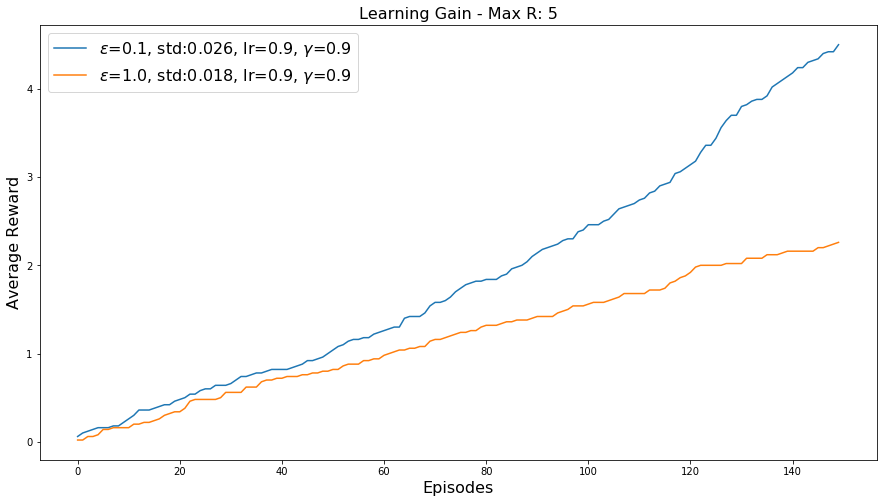

CPU times: user 4.48 s, sys: 726 ms, total: 5.21 s
Wall time: 4.67 s


In [15]:
%%time
plot_average_rewards(N=50,episodes=150,epsilon=0.1,alpha=0.9,gamma=0.9)

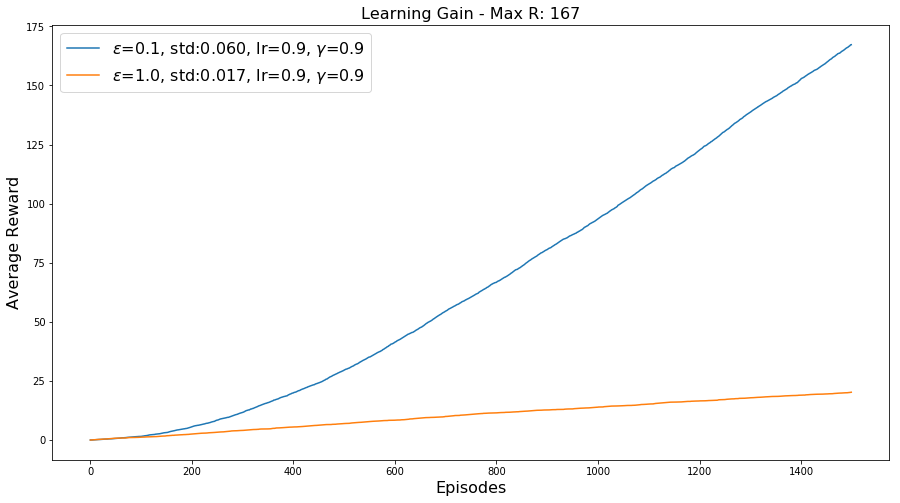

CPU times: user 55.2 s, sys: 582 ms, total: 55.7 s
Wall time: 55 s


In [16]:
%%time
plot_average_rewards(N=50,episodes=1500,epsilon=0.1,alpha=0.9,gamma=0.9)

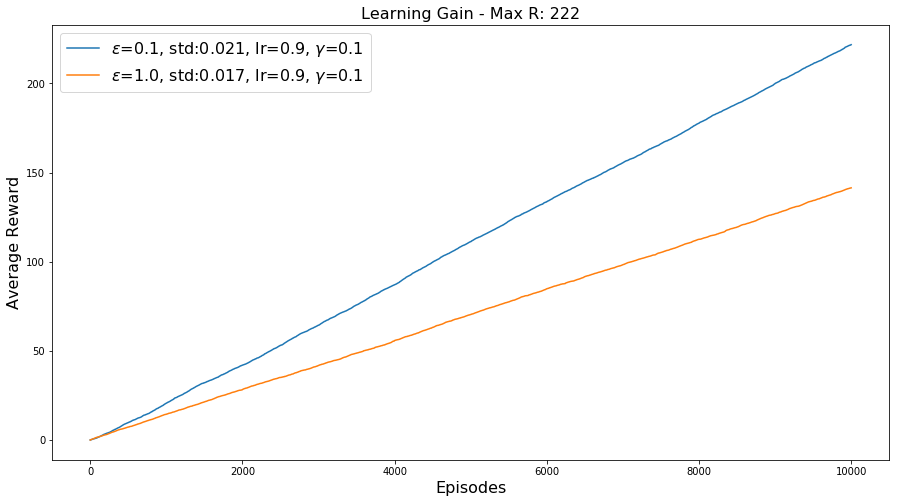

CPU times: user 3min 49s, sys: 1.79 s, total: 3min 51s
Wall time: 3min 49s


In [17]:
%%time
plot_average_rewards(N=50,episodes=10000,epsilon=0.1,alpha=0.9,gamma=0.1)

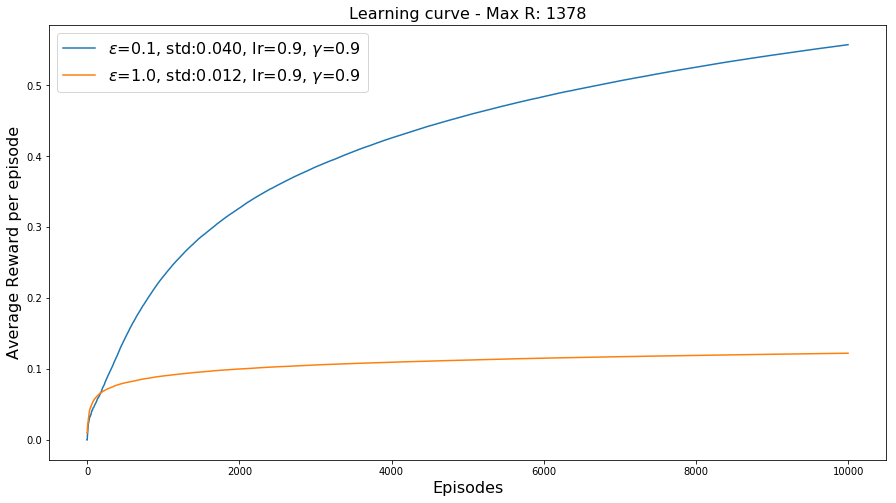

CPU times: user 14min 28s, sys: 2.34 s, total: 14min 30s
Wall time: 14min 28s


In [33]:
%%time
plot_average_rewards_per_episode(N=100,episodes=10000,epsilon=0.1,alpha=0.9,gamma=0.9)

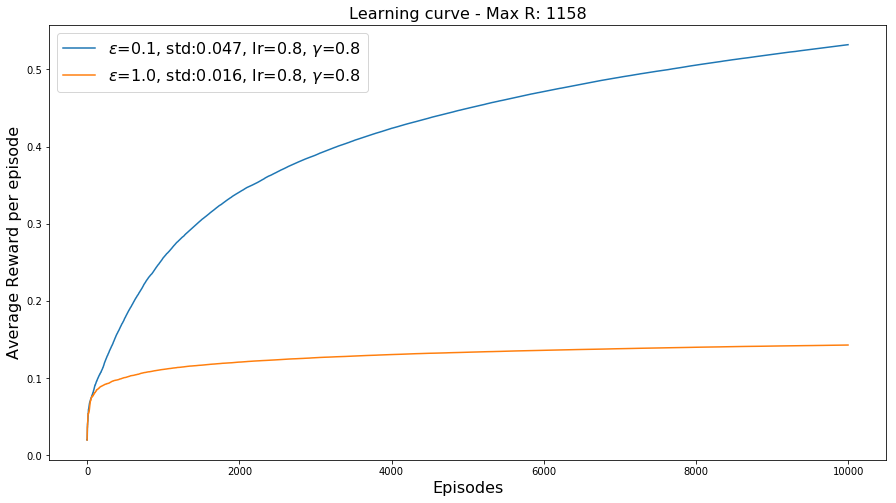

CPU times: user 6min 32s, sys: 1.11 s, total: 6min 33s
Wall time: 6min 32s


In [34]:
%%time
plot_average_rewards_per_episode(N=50,episodes=10000,epsilon=0.1,alpha=0.8,gamma=0.8)

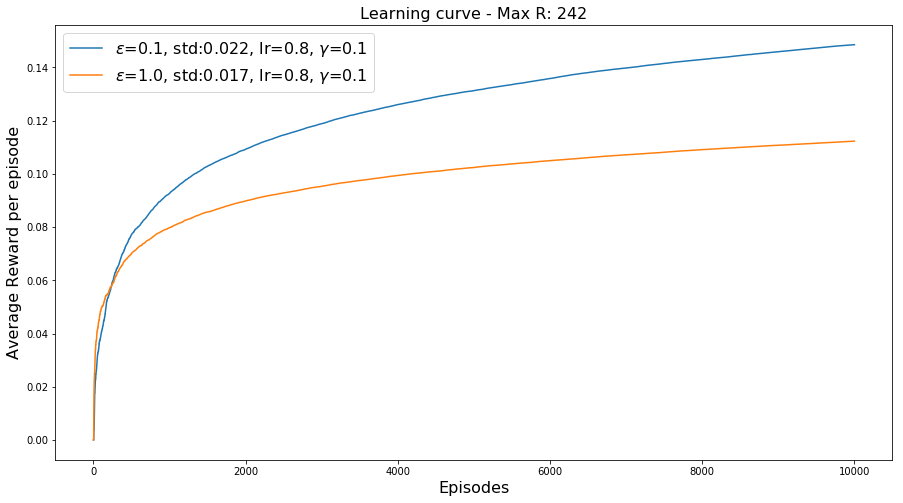

CPU times: user 4min 8s, sys: 848 ms, total: 4min 9s
Wall time: 4min 8s


In [35]:
%%time
plot_average_rewards_per_episode(N=50,episodes=10000,epsilon=0.1,alpha=0.8,gamma=0.1)

### Q-Network analysis

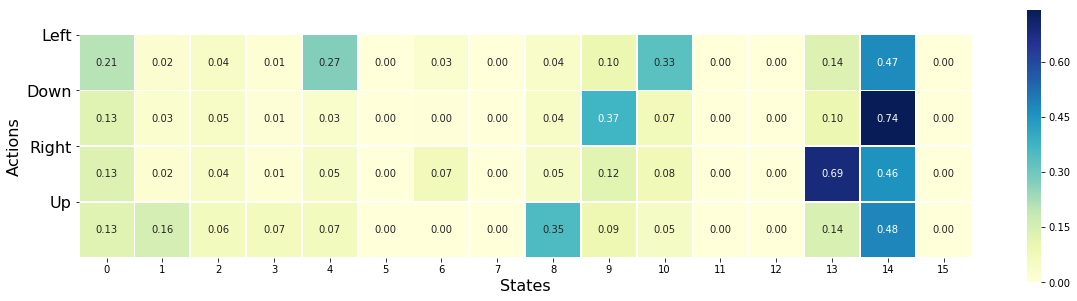

CPU times: user 9min 8s, sys: 4.97 s, total: 9min 13s
Wall time: 9min 7s


In [29]:
%%time
var_qnetwork(N=50,episodes=20000,epsilon=0.1,alpha=0.9,gamma=0.95)

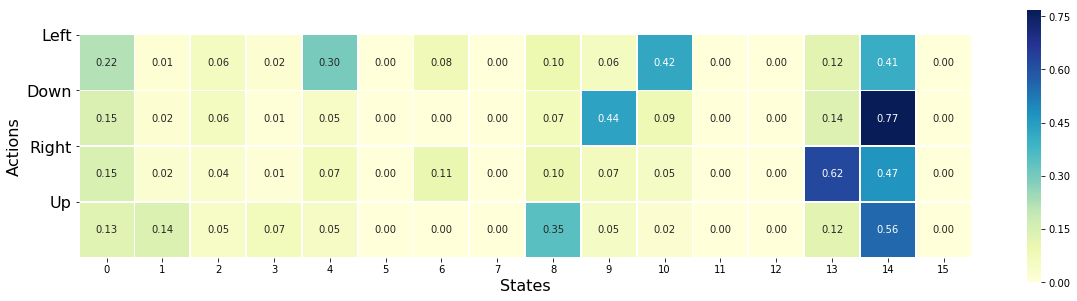

CPU times: user 10min 5s, sys: 5.11 s, total: 10min 10s
Wall time: 10min 5s


In [30]:
%%time
var_qnetwork(N=50,episodes=20000,epsilon=0.1,alpha=0.9,gamma=0.95)

### Log-Loss analysis

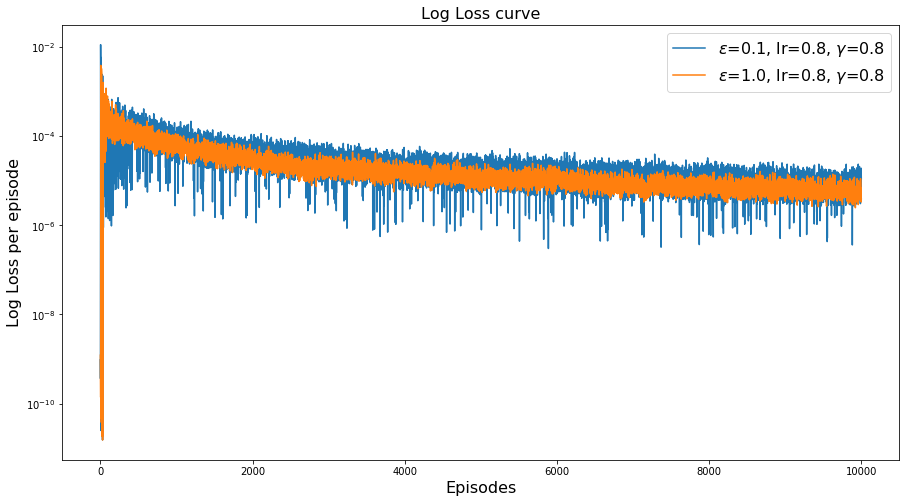

CPU times: user 3min 49s, sys: 2.46 s, total: 3min 51s
Wall time: 3min 49s


In [31]:
%%time
plot_average_loss(N=30,episodes=10000,epsilon=0.1,alpha=0.8,gamma=0.8)